# Modules

In [1]:
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

# Functions

In [2]:
# Function to read a CSV file into a pandas DataFrame
def read_csv_to_dataframe(file_path):
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

def get_baseline(performance_df):

  baseline = performance_df.loc[performance_df['HT_parallelism'] == 'Sequential']
  baseline = baseline.groupby(GROUP_BY_FIELDS)[average_fields].mean().reset_index()
  return baseline

def calculate_speedup_and_efficiency(df, baseline_df):

    merged_df = pd.merge(df, baseline_df[['HT_version', 'image_name','htDuration']], on=['HT_version', 'image_name'], suffixes=('', '_baseline'))
    merged_df['speedup'] = merged_df['htDuration_baseline'] / merged_df['htDuration']
    merged_df['efficiency'] = merged_df['speedup'] / merged_df['pbs_ncpus']

    return merged_df

def print_dataframe(df, title='', not_to_show=[]):

    if title:
      print(title)
    if df is not None and len(df) != 0:
        df_to_show = df.drop(columns=not_to_show)
        print(tabulate(df_to_show, headers='keys', tablefmt='psql'))
    else:
        print("No data to display.")

def plot_speedup_efficiency(df, image_name):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Speedup plot
    for version in df['HT_version'].unique():
        subset = df[df['HT_version'] == version]
        ax[0].plot(subset['pbs_ncpus'], subset['speedup'], marker='o', linestyle='-', label=version)

    ax[0].set_title(f'Speedup vs. Number of CPUs for {image_name}')
    ax[0].set_xlabel('Number of CPUs')
    ax[0].set_ylabel('Speedup')
    ax[0].grid(True)
    ax[0].legend()

    # Efficiency plot
    for version in df['HT_version'].unique():
        subset = df[df['HT_version'] == version]
        ax[1].plot(subset['pbs_ncpus'], subset['efficiency'], marker='o', linestyle='-', label=version)

    ax[1].set_title(f'Efficiency vs. Number of CPUs for {image_name}')
    ax[1].set_xlabel('Number of CPUs')
    ax[1].set_ylabel('Efficiency')
    ax[1].grid(True)
    ax[1].legend()

    plt.tight_layout()
    plt.show()



def generate_heatmaps(df, value_column):
    # Get unique images and versions
    images = df['image_name'].unique()
    versions = df['HT_version'].unique()

    for image in images:
        for v in versions:
            # Filter the DataFrame for the current image and version
            df_image = df.loc[(df['image_name'] == image) & (df['HT_version'] == v)].copy()

            # Create combined columns for the rows and columns as needed for the heatmap
            df_image.loc[:, 'HT_combination'] = list(zip(df_image['HT_parallelism'], df_image['pbs_place']))
            df_image.loc[:, 'pbs_combination'] = list(zip(df_image['pbs_select'], df_image['pbs_ncpus']))

            # Create the pivot table
            heatmap_data = df_image.pivot_table(
                index='HT_combination',
                columns='pbs_combination',
                values=value_column,
                aggfunc='first'
            )

            # Plot the heatmap
            plt.figure(figsize=(20, 3))
            ax = sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, linecolor='black')
            ax.set_facecolor('xkcd:light grey')  # Setting background color for NaN values if any

            plt.title(f"{v} - Heatmap for {image} based on {value_column}", fontsize=16, pad=20)
            plt.xlabel('PBS Select and Cpus', fontsize=12)
            plt.ylabel('Parallelism and PBS Place)')

            # Set x-tick labels above the heatmap, rotated horizontally and adjust font size
            ax.xaxis.tick_top()  # Move the x-axis labels to the top
            ax.xaxis.set_label_position('top')  # Ensure the xlabel is on the top as well
            ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=10)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

            plt.show()

# Tests setup & baseline

In [3]:
not_to_show = ['cluster_similar_lines', 'cluster_rho_threshold', 'cluster_theta_threshold',
                    'hough_theta', 'ppht_line_gap', 'ppht_line_len', 'gb_kernel_size', 'gb_sigma', 'sed_threshold',
                    'output_disabled', 'sed_scale_factor', 'hough_vote_threshold', 'histogram_equalization',
                    'greyscale_conversion', 'gaussian_blur', 'sobel_edge_detection', 'sampling_rate']


GROUP_BY_FIELDS = ['pbs_ncpus', 'pbs_select', 'HT_parallelism', 'pbs_mem', 'pbs_place', 'omp_threads', 'HT_version', 'image_name', 'cluster_similar_lines', 'cluster_rho_threshold',
 'cluster_theta_threshold', 'hough_theta', 'ppht_line_gap', 'ppht_line_len', 'gb_kernel_size', 'gb_sigma', 'sed_threshold', 'output_disabled',
 'sed_scale_factor', 'hough_vote_threshold', 'histogram_equalization', 'greyscale_conversion',
 'gaussian_blur', 'sobel_edge_detection', 'sampling_rate']

average_fields = ['total_duration', 'htDuration', 'precision', 'recall', 'preprocessingDuration']
PERFORMANCE_PATH = 'performance.csv'

performance_df = read_csv_to_dataframe(PERFORMANCE_PATH)

performance_df['HT_parallelism'] = performance_df['HT_parallelism'].fillna('Sequential')
print(f"DF LEN: {len(performance_df)}")
performance_df = performance_df.groupby(GROUP_BY_FIELDS).mean().reset_index()
print(f"DF LEN: {len(performance_df)}")
images = performance_df['image_name'].unique()
versions = performance_df['HT_version'].unique()
parallelism = performance_df['HT_parallelism'].unique()

for i in images:
  print(f"Image: {i} -> Tests:", len(performance_df.loc[performance_df["image_name"] == i]), "Total time: ", round(performance_df.loc[performance_df["image_name"] == i]['total_duration'].sum() / 60, 0), " minutes")
for v in versions:
  print(f"Version: {v} -> Tests:", len(performance_df.loc[performance_df["HT_version"] == v]))
for p in parallelism:
  print(f"Parallelism: {p} -> Tests:", len(performance_df.loc[performance_df["HT_parallelism"] == p]))



DF LEN: 1188
DF LEN: 594
Image: syn_img_10k -> Tests: 198 Total time:  154.0  minutes
Image: syn_img_20k -> Tests: 198 Total time:  494.0  minutes
Image: syn_img_5k -> Tests: 198 Total time:  54.0  minutes
Version: HT -> Tests: 222
Version: PHT -> Tests: 222
Version: PPHT -> Tests: 150
Parallelism: Sequential -> Tests: 18
Parallelism: Hybrid -> Tests: 144
Parallelism: MPI -> Tests: 216
Parallelism: openMP -> Tests: 216


In [4]:

baseline = get_baseline(performance_df)
print_dataframe(baseline, title=f"\nBaseline tests", not_to_show=not_to_show)
performance_df = calculate_speedup_and_efficiency(performance_df, baseline)
print_dataframe(performance_df[performance_df['HT_parallelism'] == 'Sequential'][:5], title=f"Performance tests (examples)", not_to_show=not_to_show)

# Step 1: Create a new column for combined pbs settings
performance_df['select-ncpus'] = list(zip(performance_df['pbs_select'], (performance_df['pbs_ncpus'] / performance_df['pbs_select'])))




Baseline tests
+----+-------------+--------------+------------------+-----------+--------------+---------------+--------------+--------------+------------------+--------------+-------------+----------+-------------------------+
|    |   pbs_ncpus |   pbs_select | HT_parallelism   |   pbs_mem | pbs_place    |   omp_threads | HT_version   | image_name   |   total_duration |   htDuration |   precision |   recall |   preprocessingDuration |
|----+-------------+--------------+------------------+-----------+--------------+---------------+--------------+--------------+------------------+--------------+-------------+----------+-------------------------|
|  0 |           1 |            1 | Sequential       |         8 | pack-excl    |             1 | HT           | syn_img_10k  |          4.91038 |     1.78951  |   0.946809  | 0.89     |                2.67556  |
|  1 |           1 |            1 | Sequential       |         8 | pack-excl    |             1 | HT           | syn_img_20k  |     

# Line chart for a measure grouped by image and parallelization library.

SHow charts of each ht version for that image and parallelization library. The measure to use for lines can be specified in 'var'.
The dataframe contains the best performative configuration for each ht version.
Also precision and recall (averaged) are shown.


Sample: syn_img_5k - Parallelism: openMP - Best configuration of each HT version.
+-----+-------------+--------------+------------------+-----------+-------------+---------------+--------------+--------------+-------------------------+-------------------------+---------------------------+---------------+-----------------+-----------------+------------------+------------+-----------------+-------------------+--------------------+------------------------+--------------------------+------------------------+-----------------+------------------------+-----------------+------------------+--------------+--------------------------+-------------+----------+-------------------------+----------+-----------------------+-----------+--------------+----------------+
|     |   pbs_ncpus |   pbs_select | HT_parallelism   |   pbs_mem | pbs_place   |   omp_threads | HT_version   | image_name   | cluster_similar_lines   |   cluster_rho_threshold |   cluster_theta_threshold |   hough_theta |   ppht_line_ga

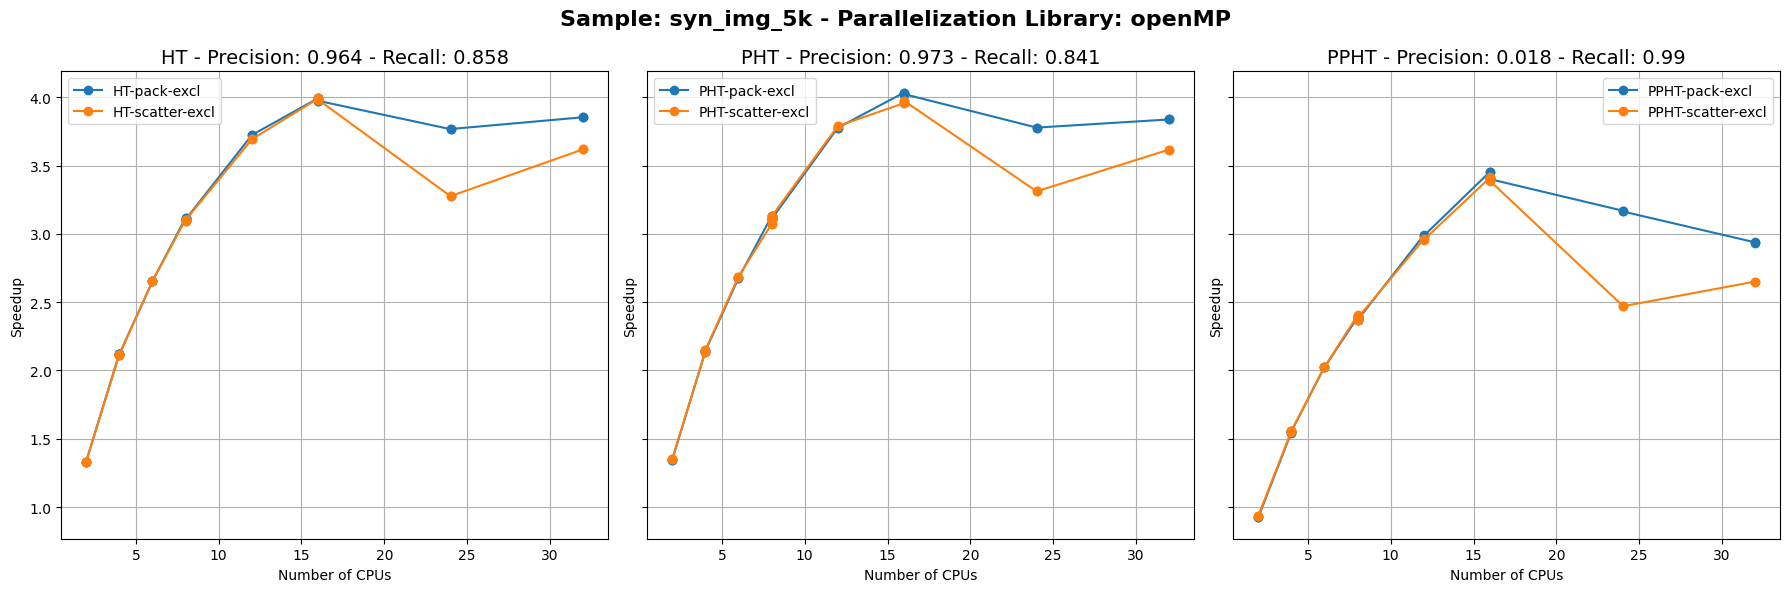

Sample: syn_img_10k - Parallelism: openMP - Best configuration of each HT version.
+------+-------------+--------------+------------------+-----------+-------------+---------------+--------------+--------------+-------------------------+-------------------------+---------------------------+---------------+-----------------+-----------------+------------------+------------+-----------------+-------------------+--------------------+------------------------+--------------------------+------------------------+-----------------+------------------------+-----------------+------------------+--------------+--------------------------+-------------+----------+-------------------------+----------+-----------------------+-----------+--------------+----------------+
|      |   pbs_ncpus |   pbs_select | HT_parallelism   |   pbs_mem | pbs_place   |   omp_threads | HT_version   | image_name   | cluster_similar_lines   |   cluster_rho_threshold |   cluster_theta_threshold |   hough_theta |   ppht_line

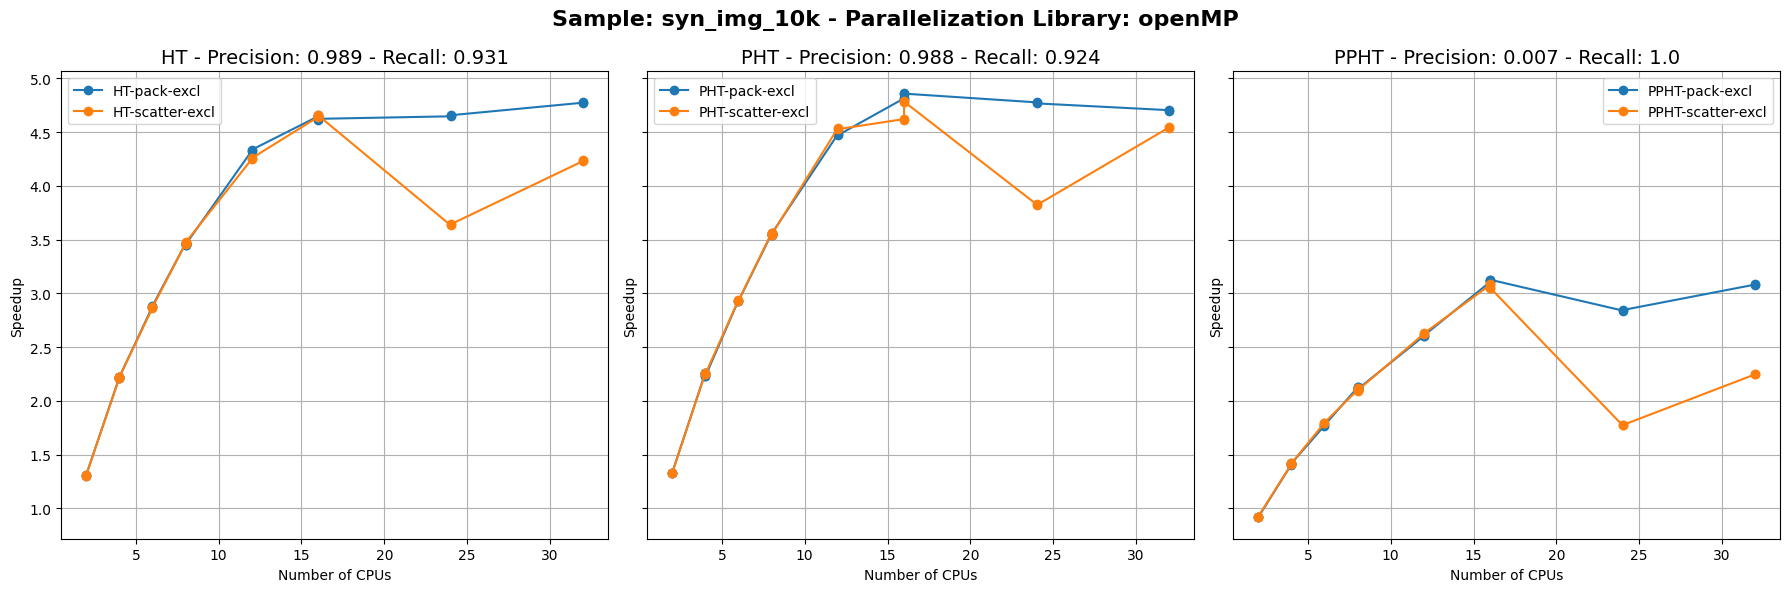

Sample: syn_img_20k - Parallelism: openMP - Best configuration of each HT version.
+------+-------------+--------------+------------------+-----------+--------------+---------------+--------------+--------------+-------------------------+-------------------------+---------------------------+---------------+-----------------+-----------------+------------------+------------+-----------------+-------------------+--------------------+------------------------+--------------------------+------------------------+-----------------+------------------------+-----------------+------------------+--------------+--------------------------+-------------+----------+-------------------------+----------+-----------------------+-----------+--------------+----------------+
|      |   pbs_ncpus |   pbs_select | HT_parallelism   |   pbs_mem | pbs_place    |   omp_threads | HT_version   | image_name   | cluster_similar_lines   |   cluster_rho_threshold |   cluster_theta_threshold |   hough_theta |   ppht_li

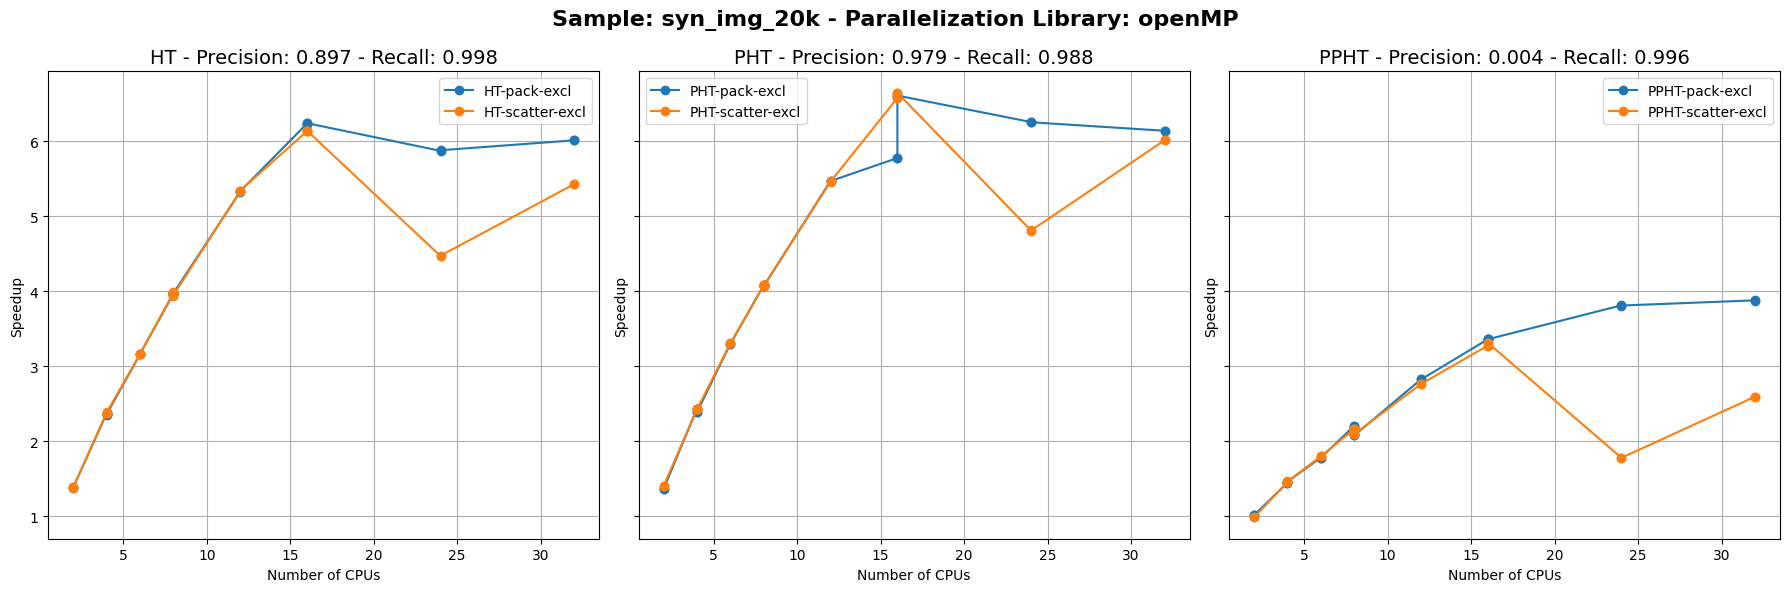

Sample: syn_img_5k - Parallelism: MPI - Best configuration of each HT version.
+----+-------------+--------------+------------------+-----------+--------------+---------------+--------------+--------------+-------------------------+-------------------------+---------------------------+---------------+-----------------+-----------------+------------------+------------+-----------------+-------------------+--------------------+------------------------+--------------------------+------------------------+-----------------+------------------------+-----------------+------------------+--------------+--------------------------+-------------+----------+-------------------------+----------+-----------------------+-----------+--------------+----------------+
|    |   pbs_ncpus |   pbs_select | HT_parallelism   |   pbs_mem | pbs_place    |   omp_threads | HT_version   | image_name   | cluster_similar_lines   |   cluster_rho_threshold |   cluster_theta_threshold |   hough_theta |   ppht_line_gap |

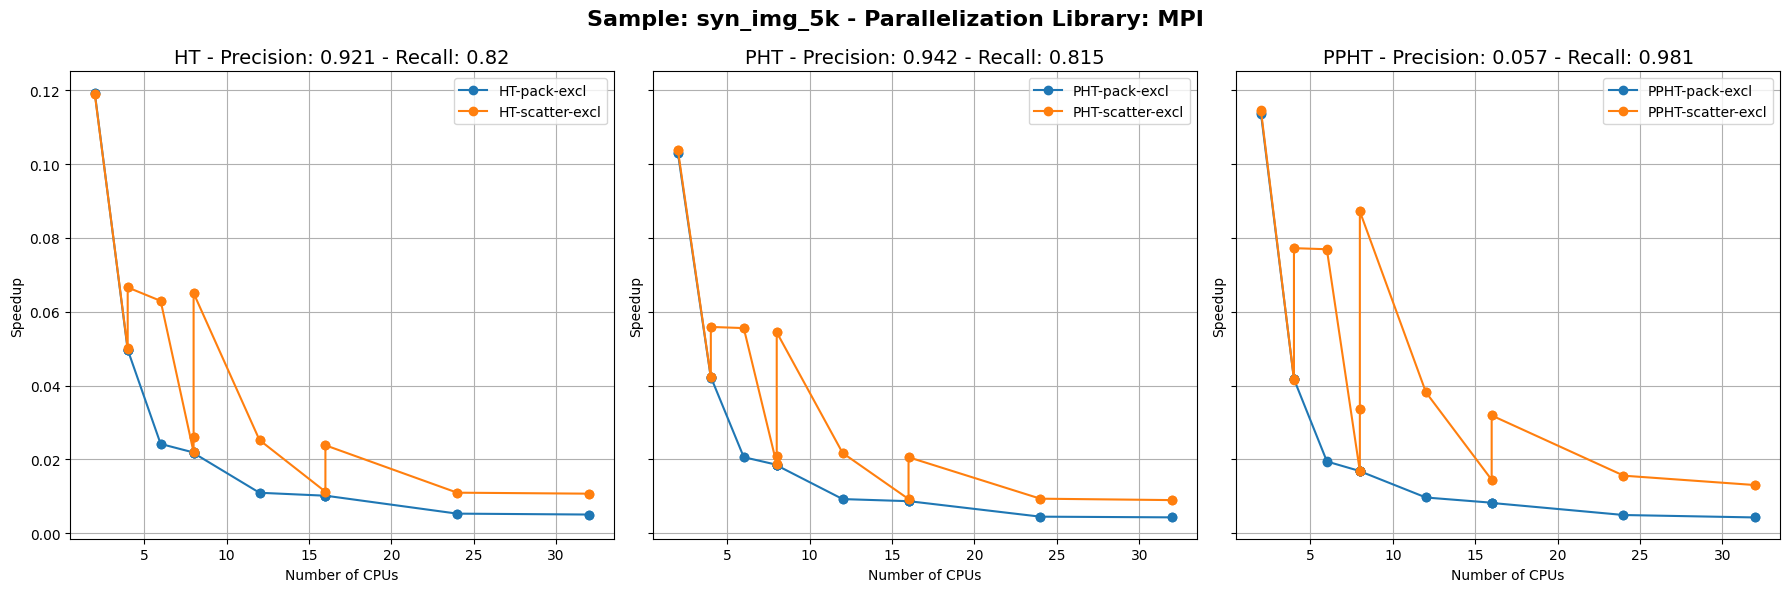

Sample: syn_img_10k - Parallelism: MPI - Best configuration of each HT version.
+----+-------------+--------------+------------------+-----------+--------------+---------------+--------------+--------------+-------------------------+-------------------------+---------------------------+---------------+-----------------+-----------------+------------------+------------+-----------------+-------------------+--------------------+------------------------+--------------------------+------------------------+-----------------+------------------------+-----------------+------------------+--------------+--------------------------+-------------+----------+-------------------------+----------+-----------------------+-----------+--------------+----------------+
|    |   pbs_ncpus |   pbs_select | HT_parallelism   |   pbs_mem | pbs_place    |   omp_threads | HT_version   | image_name   | cluster_similar_lines   |   cluster_rho_threshold |   cluster_theta_threshold |   hough_theta |   ppht_line_gap 

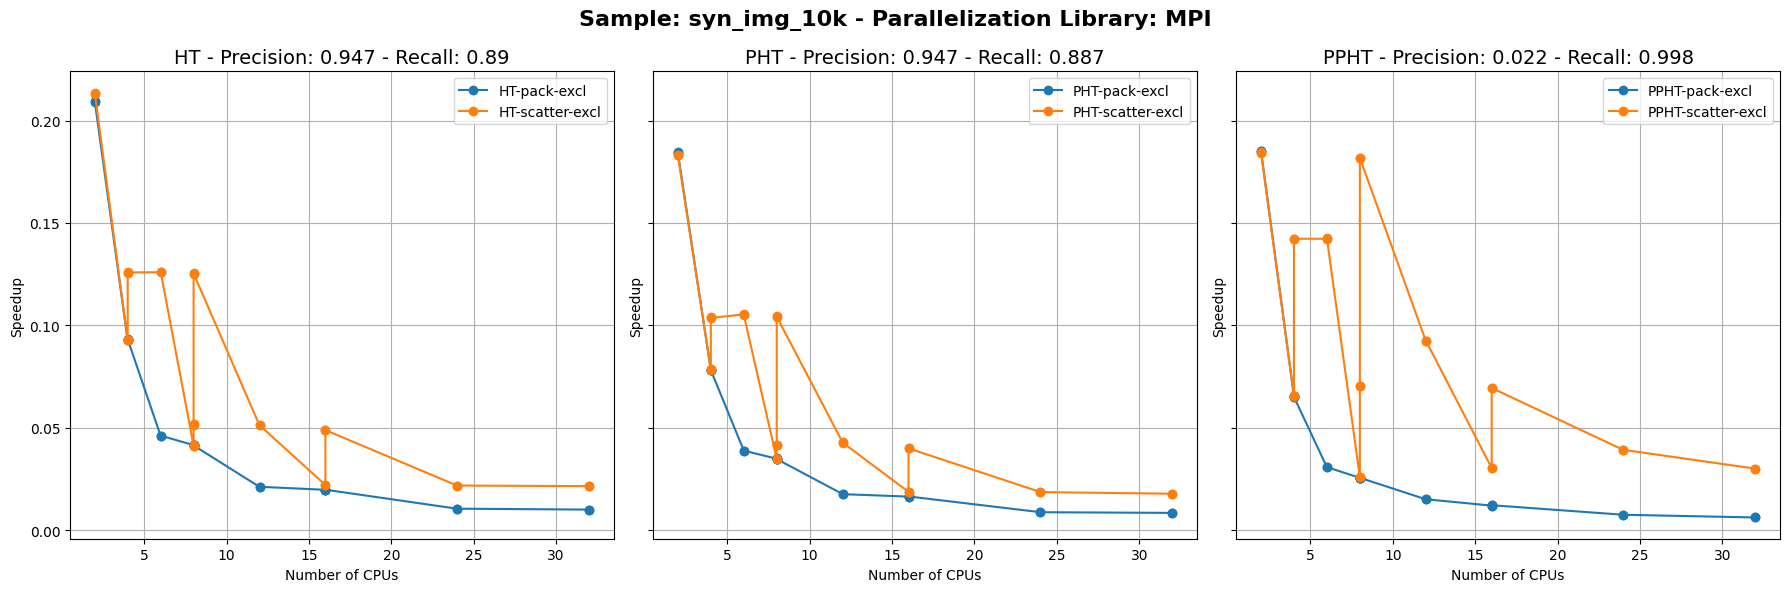

Sample: syn_img_20k - Parallelism: MPI - Best configuration of each HT version.
+-----+-------------+--------------+------------------+-----------+--------------+---------------+--------------+--------------+-------------------------+-------------------------+---------------------------+---------------+-----------------+-----------------+------------------+------------+-----------------+-------------------+--------------------+------------------------+--------------------------+------------------------+-----------------+------------------------+-----------------+------------------+--------------+--------------------------+-------------+----------+-------------------------+----------+-----------------------+-----------+--------------+----------------+
|     |   pbs_ncpus |   pbs_select | HT_parallelism   |   pbs_mem | pbs_place    |   omp_threads | HT_version   | image_name   | cluster_similar_lines   |   cluster_rho_threshold |   cluster_theta_threshold |   hough_theta |   ppht_line_ga

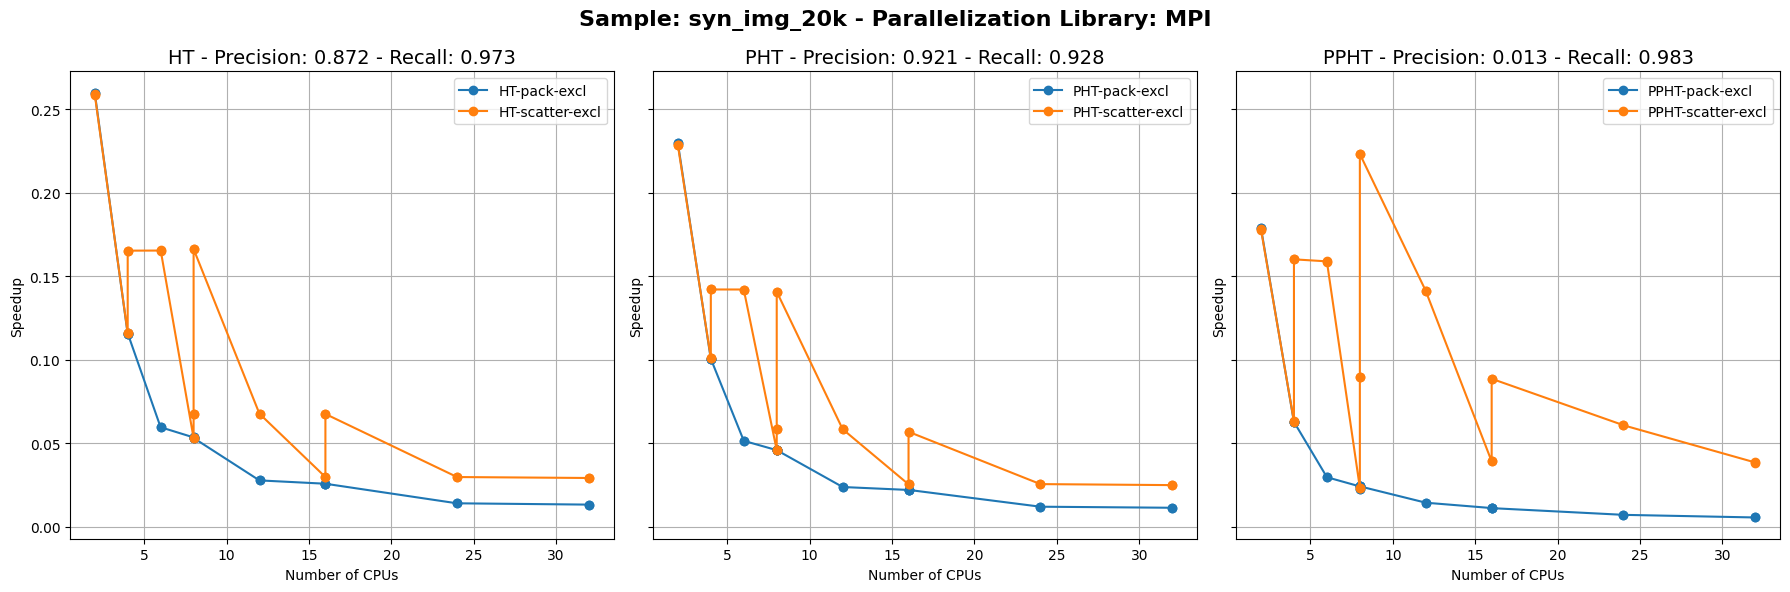

Sample: syn_img_5k - Parallelism: Hybrid - Best configuration of each HT version.
+-----+-------------+--------------+------------------+-----------+--------------+---------------+--------------+--------------+-------------------------+-------------------------+---------------------------+---------------+-----------------+-----------------+------------------+------------+-----------------+-------------------+--------------------+------------------------+--------------------------+------------------------+-----------------+------------------------+-----------------+------------------+--------------+--------------------------+-------------+----------+-------------------------+----------+-----------------------+-----------+--------------+----------------+
|     |   pbs_ncpus |   pbs_select | HT_parallelism   |   pbs_mem | pbs_place    |   omp_threads | HT_version   | image_name   | cluster_similar_lines   |   cluster_rho_threshold |   cluster_theta_threshold |   hough_theta |   ppht_line_

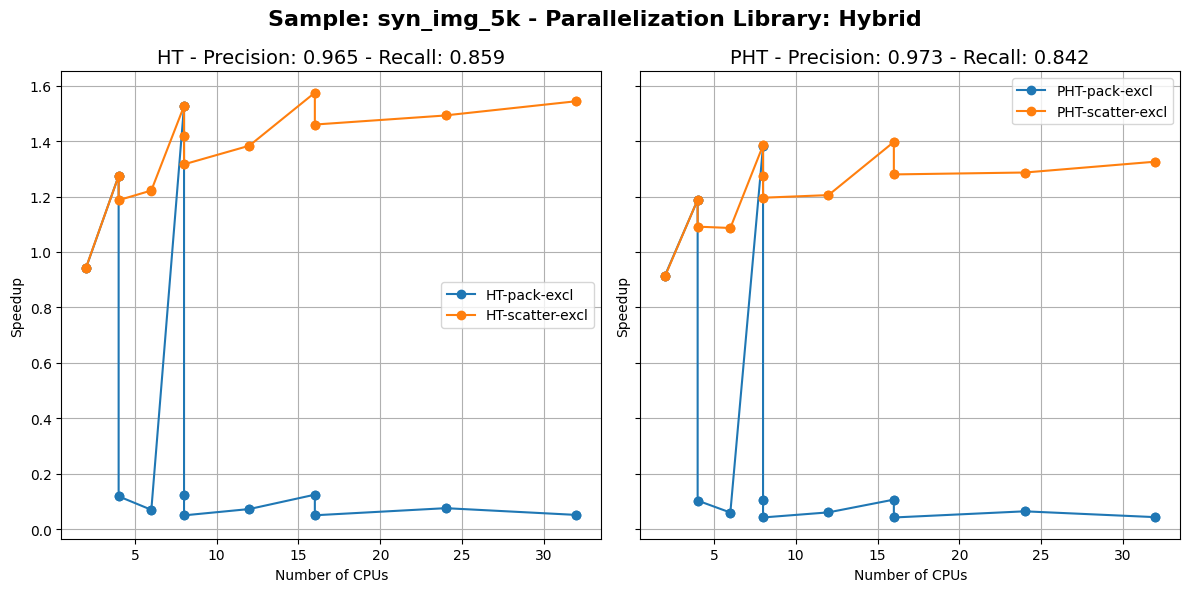

Sample: syn_img_10k - Parallelism: Hybrid - Best configuration of each HT version.
+------+-------------+--------------+------------------+-----------+--------------+---------------+--------------+--------------+-------------------------+-------------------------+---------------------------+---------------+-----------------+-----------------+------------------+------------+-----------------+-------------------+--------------------+------------------------+--------------------------+------------------------+-----------------+------------------------+-----------------+------------------+--------------+--------------------------+-------------+----------+-------------------------+----------+-----------------------+-----------+--------------+----------------+
|      |   pbs_ncpus |   pbs_select | HT_parallelism   |   pbs_mem | pbs_place    |   omp_threads | HT_version   | image_name   | cluster_similar_lines   |   cluster_rho_threshold |   cluster_theta_threshold |   hough_theta |   ppht_li

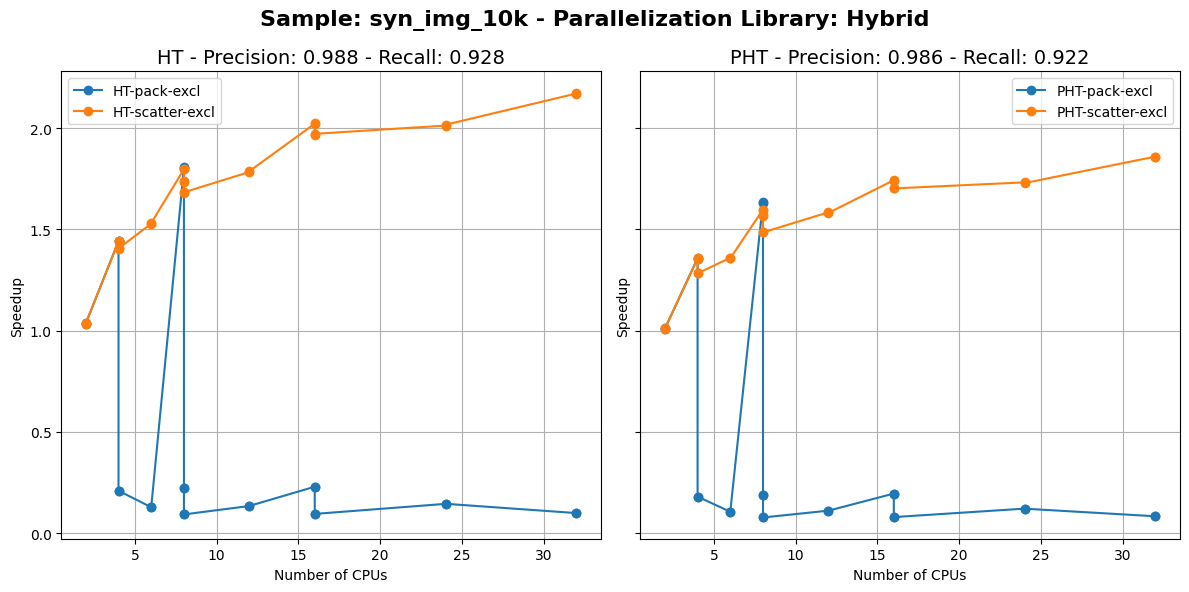

Sample: syn_img_20k - Parallelism: Hybrid - Best configuration of each HT version.
+------+-------------+--------------+------------------+-----------+--------------+---------------+--------------+--------------+-------------------------+-------------------------+---------------------------+---------------+-----------------+-----------------+------------------+------------+-----------------+-------------------+--------------------+------------------------+--------------------------+------------------------+-----------------+------------------------+-----------------+------------------+--------------+--------------------------+-------------+----------+-------------------------+----------+-----------------------+-----------+--------------+----------------+
|      |   pbs_ncpus |   pbs_select | HT_parallelism   |   pbs_mem | pbs_place    |   omp_threads | HT_version   | image_name   | cluster_similar_lines   |   cluster_rho_threshold |   cluster_theta_threshold |   hough_theta |   ppht_li

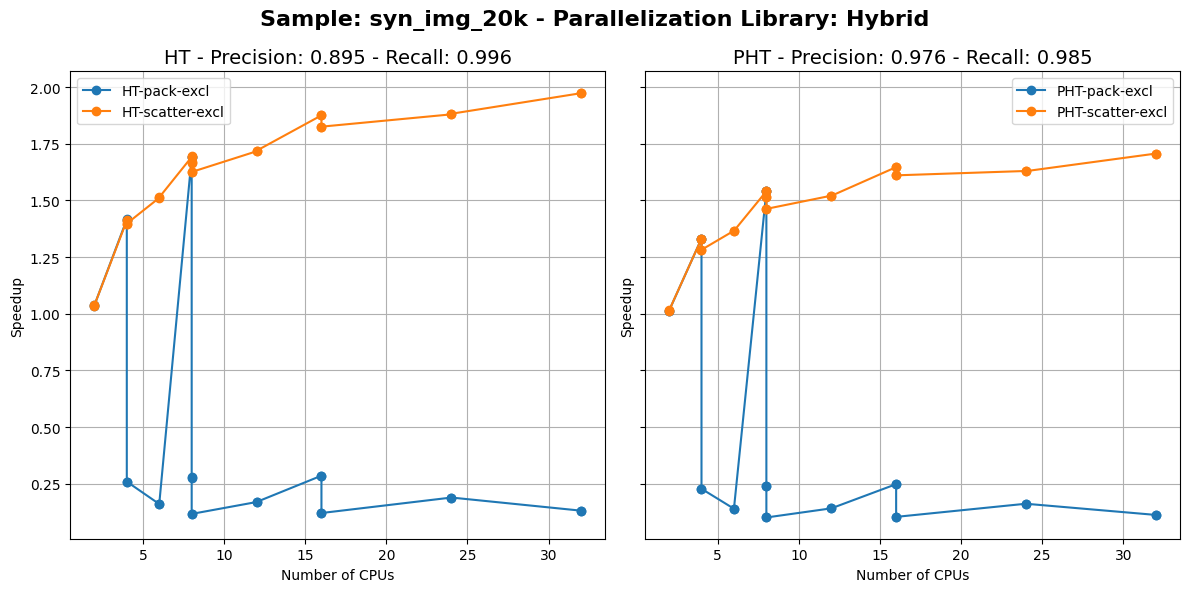

In [8]:
def inspect_performance(df, parallelisms, img_names, versions, var, basepath):

  for p in parallelisms:
    df_1 = df.loc[(df['HT_parallelism'] == p)]

    for i in img_names:
      df_2 = df_1.loc[(df_1['image_name'] == i)]
      if p == 'Hybrid':
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
      else:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharey=True)
      min_htDuration_rows = []

      for k, v in enumerate(versions):
        if (p == 'Hybrid' and v == 'PPHT'):
          continue

        df_3 = df_2.loc[(df_2['HT_version'] == v)]

        grouped = df_3.groupby('pbs_place')

        for name, group in grouped:
            axs[k].plot(group['pbs_ncpus'], group[var], marker='o', linestyle='-', label=f"{v}-{name}")


        axs[k].set_title(f"{v} - Precision: {round(df_3['precision'].mean(),3)} - Recall: {round(df_3['recall'].mean(),3)}",fontsize=14)
        axs[k].set_xlabel('Number of CPUs')
        axs[k].set_ylabel('Speedup')
        axs[k].legend()
        axs[k].grid(True)

        curr_baseline = baseline.loc[(baseline['HT_version'] == v) & (baseline['image_name'] == i)]

        # Finding the row with the minimum htDuration for this HT_version
        min_htDuration_row = df_3.loc[df_3['htDuration'].idxmin()]
        min_htDuration_rows.append(min_htDuration_row)
        #axs[k].axhline(curr_baseline[curr_baseline['pbs_place'] == 'pack-excl']['htDuration'].iloc[0], color='blue', linestyle='--')  # Linea orizzontale a y=0.5
        #axs[k].axhline(curr_baseline[curr_baseline['pbs_place'] == 'scatter-excl']['htDuration'].iloc[0], color='red', linestyle='--')  # Linea orizzontale a y=0.5

      min_htDuration_df = pd.DataFrame(min_htDuration_rows)
      print_dataframe(min_htDuration_df, f"Sample: {i} - Parallelism: {p} - Best configuration of each HT version.")

      plt.suptitle(f'Sample: {i} - Parallelization Library: {p}', fontsize=16, fontweight='bold')
      plt.tight_layout()
      plt.savefig(f"{basepath}lc-{i}-{p}.png", bbox_inches='tight')
      plt.show()

var = 'speedup'

ht_parallelism = ['openMP','MPI']
img_names = ['syn_img_5k','syn_img_10k','syn_img_20k']
basepath = "line_charts/"
inspect_performance(performance_df, ht_parallelism, img_names, versions, var, basepath)
inspect_performance(performance_df, ['Hybrid'], img_names, versions, var, basepath)

# Heatmaps for each ht version and image.
Columns: (select, ncpus)
Rows: (parallelism, pbs place)

(pbs_place put there only for presentation purposes)

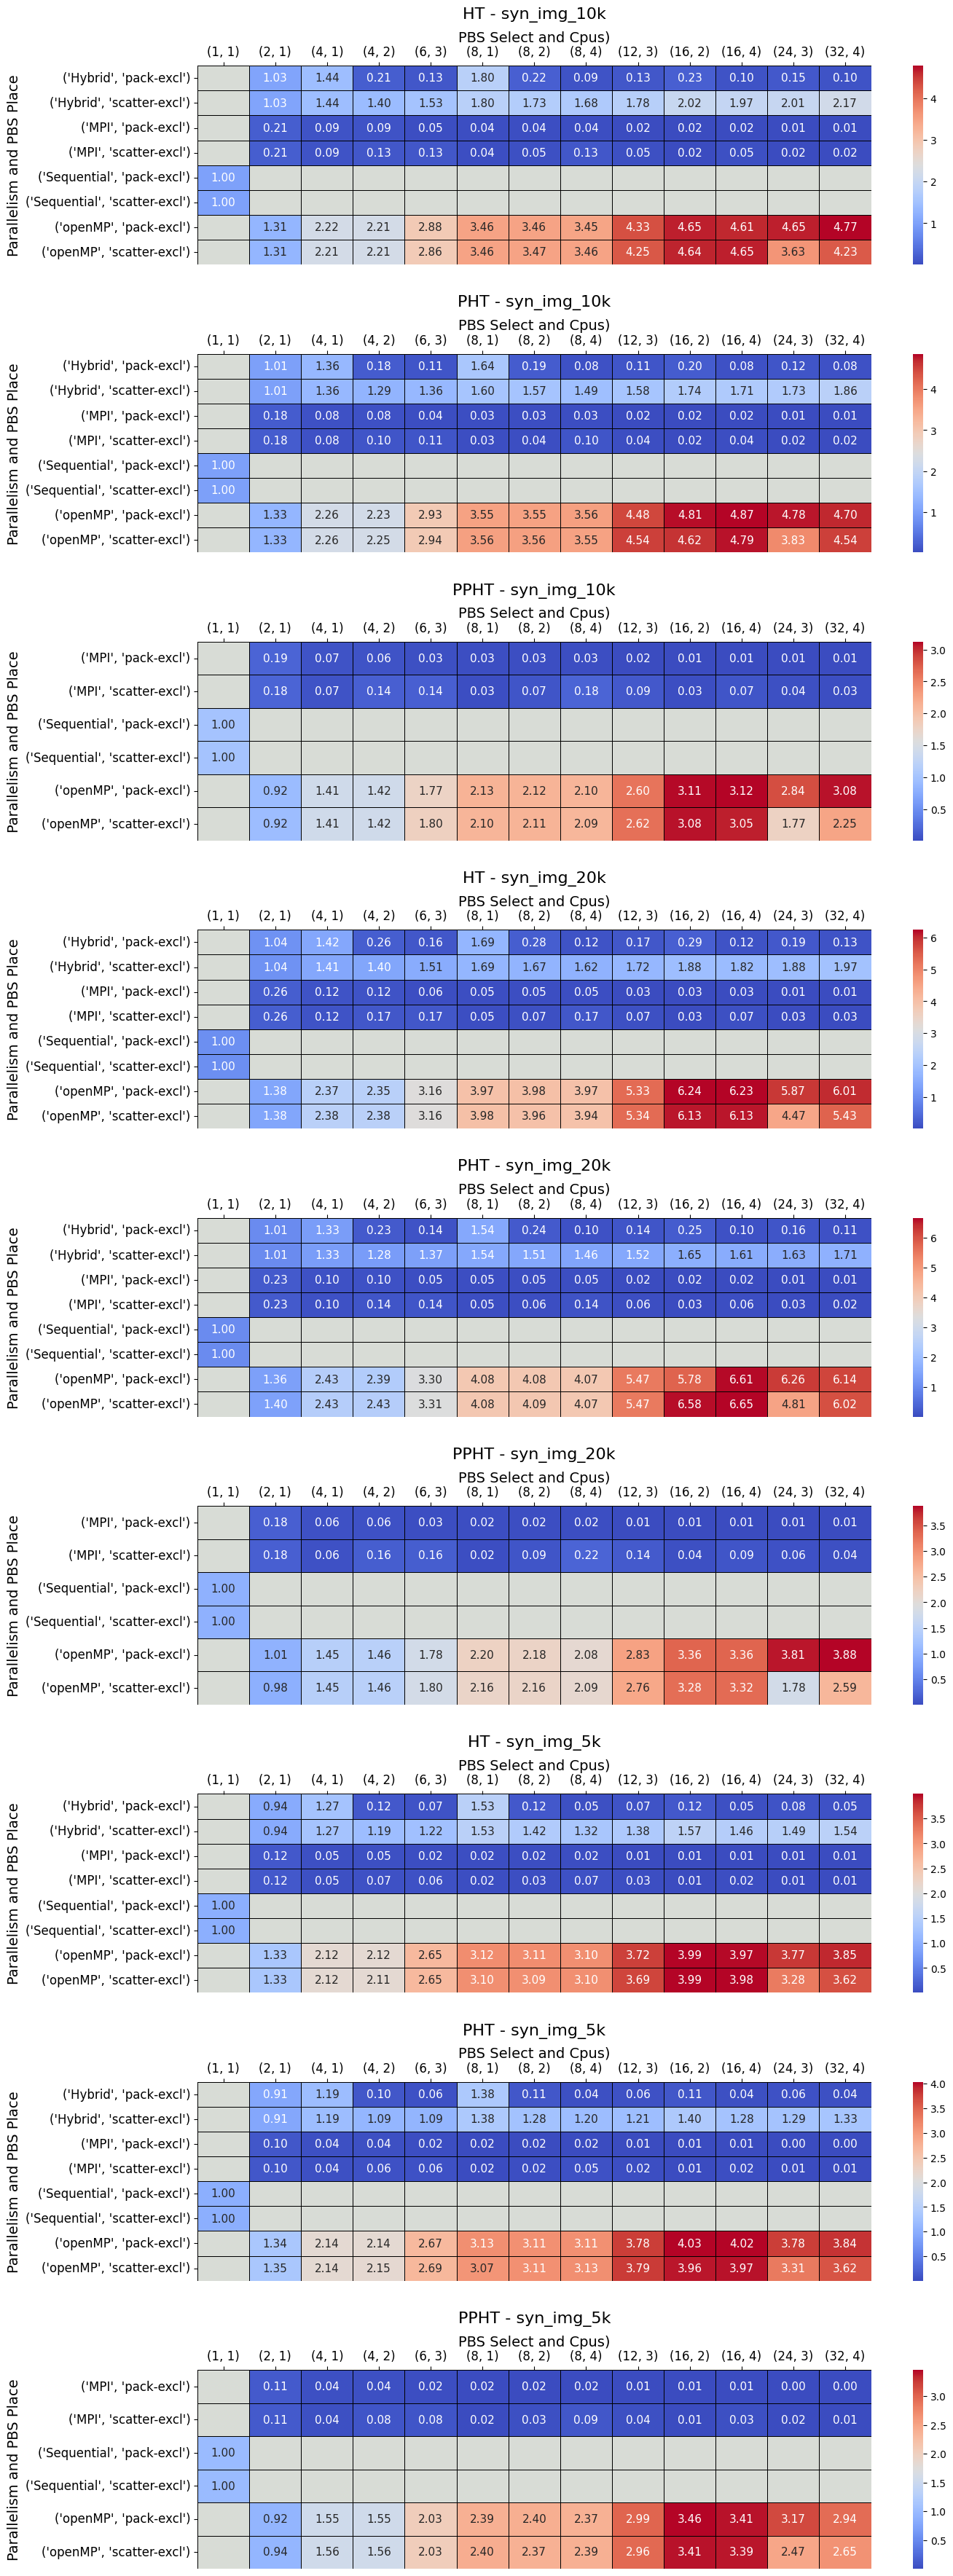

In [9]:
def generate_heatmaps(df, value_column, basepath):
    images = df['image_name'].unique()
    versions = df['HT_version'].unique()

    num_images = len(images)
    num_versions = len(versions)
    total_plots = num_images * num_versions

    fig, axes = plt.subplots(total_plots, 1, figsize=(15, 4 * total_plots))  # Increased the vertical size
    if total_plots == 1:
        axes = [axes]  #axes is always iterable

    plot_count = 0

    for image in images:
        for v in versions:

            df_image = df.loc[(df['image_name'] == image) & (df['HT_version'] == v)].copy()

            df_image.loc[:, 'HT_combination'] = list(zip(df_image['HT_parallelism'], df_image['pbs_place']))
            df_image.loc[:, 'pbs_combination'] = list(zip(df_image['pbs_ncpus'], df_image['pbs_select']))

            heatmap_data = df_image.pivot_table(
                index='HT_combination',
                columns='pbs_combination',
                values=value_column,
                aggfunc='first'
            )

            ax = axes[plot_count]
            sns.heatmap(heatmap_data, annot=True,annot_kws={"size": 11}, fmt=".2f", cmap='coolwarm', linewidths=.5, linecolor='black', ax=ax)
            ax.set_facecolor('xkcd:light grey')
            ax.set_title(f"{v} - {image}", fontsize=16, pad=12)
            ax.set_xlabel('PBS Select and Cpus)', fontsize=14)
            ax.set_ylabel('Parallelism and PBS Place', fontsize=14)
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position('top')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=12)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)

            plot_count += 1

            plt.savefig(f"{basepath}hm-{image}-{v}.png", bbox_inches='tight')

    plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=2.0)
    fig.savefig(f"{basepath}heatmaps.png", bbox_inches='tight')
    plt.show()

basepath = "heatmaps/"
generate_heatmaps(performance_df, 'speedup', basepath)
